In [85]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
#full lightcast data pull
file_path = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/Analysis/lc_data24.csv"  
df = pd.read_csv(file_path)

#drop unnecessary columns
df = df.drop(['Area Bucket', 'Industry Bucket'], axis=1)

#drop non-county data
df = df[~df['Area Name'].str.contains("county not reported", case=False, na=False)]

#get that crosswalk in there
file_path_cw = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/GitHub/Economic-Complexity/county20.csv"  
cw = pd.read_csv(file_path_cw)

#merge it up
df = df.merge(cw, left_on="Area", right_on="GEOID", how="left")

#drop the GEOID, it's already represented with "Area"
df = df.drop(['GEOID'], axis=1)

In [87]:
print(df.head(25))

           Area Name                                      Industry Name  \
0   Adair County, IA                                    Crop Production   
1   Adair County, IA                                  Animal Production   
2   Adair County, IA                            Timber Tract Operations   
3   Adair County, IA  Forest Nurseries and Gathering of Forest Products   
4   Adair County, IA                                            Logging   
5   Adair County, IA                                    Finfish Fishing   
6   Adair County, IA                                  Shellfish Fishing   
7   Adair County, IA                               Other Marine Fishing   
8   Adair County, IA                               Hunting and Trapping   
9   Adair County, IA                                     Cotton Ginning   
10  Adair County, IA        Soil Preparation, Planting, and Cultivating   
11  Adair County, IA              Crop Harvesting, Primarily by Machine   
12  Adair County, IA  Pos

In [88]:
'''
Jobs_county = number of jobs in the county in that industry
Jobs_CZ = number of jobs in that cz in that industry
Total_Jobs_CZ = total number of jobs in each cz
'''
# Ensure 'Jobs_county' column is numeric. Changed the name for additional clarity
df['Jobs_county'] = pd.to_numeric(df['Jobs'], errors='coerce') #transformed from Jobs

# Combine 'Jobs_county' for all counties in each CZ
df['Jobs_CZ'] = df.groupby(['CZ20', 'Industry'])['Jobs'].transform('sum') #transformed from Total_Employment

# Compute total employment in each commuting zone across all industries
df['Total_Jobs_CZ'] = df.groupby('CZ20')['Jobs'].transform('sum') #transformed from Total_CZ_Employment

# Calculate industry's share of total employment in the commuting zone
df['Employment_Share'] = df['Jobs_CZ'] / df['Total_Jobs_CZ']

# Compute log transformations
df['Log_Total_Jobs_CZ'] = np.log(df['Total_Jobs_CZ'])
df['Log_Total_Jobs_CZ_Squared'] = df['Log_Total_Jobs_CZ'] ** 2

# Drop any remaining duplicates (just to be safe)
df_cz = df.drop_duplicates(subset=['CZ20', 'Industry'])

#collapsed data
#df = df[['CZ20', 'Area', 'Area Name', 'Industry', 'Industry Name', 'Jobs', 'Total_CZ_Employment', 'Employment_Share']].drop_duplicates()

'''
# Ensure 'Jobs_county' column is numeric
df['Jobs_county'] = pd.to_numeric(df['Jobs'], errors='coerce')  

# Aggregate jobs at the CZ level (sum across counties)
df_cz = df.groupby(['CZ20', 'Industry', 'Industry Name'], as_index=False).agg({
    'Jobs_county': 'sum',  # Total jobs in CZ for the industry
    'Total_Jobs_CZ': 'first',  # Total jobs in CZ (same for all counties)
})

# Recalculate employment share
df_cz['Employment_Share'] = df_cz['Jobs_county'] / df_cz['Total_Jobs_CZ']

# Compute log transformations
df_cz['Log_Total_Jobs_CZ'] = np.log(df_cz['Total_Jobs_CZ'])
df_cz['Log_Total_Jobs_CZ_Squared'] = df_cz['Log_Total_Jobs_CZ'] ** 2

# Drop any remaining duplicates (just to be safe)
df_cz = df_cz.drop_duplicates(subset=['CZ20', 'Industry'])

print(df_cz.head())  # Check that we now have one row per industry per CZ
'''

"\n# Ensure 'Jobs_county' column is numeric\ndf['Jobs_county'] = pd.to_numeric(df['Jobs'], errors='coerce')  \n\n# Aggregate jobs at the CZ level (sum across counties)\ndf_cz = df.groupby(['CZ20', 'Industry', 'Industry Name'], as_index=False).agg({\n    'Jobs_county': 'sum',  # Total jobs in CZ for the industry\n    'Total_Jobs_CZ': 'first',  # Total jobs in CZ (same for all counties)\n})\n\n# Recalculate employment share\ndf_cz['Employment_Share'] = df_cz['Jobs_county'] / df_cz['Total_Jobs_CZ']\n\n# Compute log transformations\ndf_cz['Log_Total_Jobs_CZ'] = np.log(df_cz['Total_Jobs_CZ'])\ndf_cz['Log_Total_Jobs_CZ_Squared'] = df_cz['Log_Total_Jobs_CZ'] ** 2\n\n# Drop any remaining duplicates (just to be safe)\ndf_cz = df_cz.drop_duplicates(subset=['CZ20', 'Industry'])\n\nprint(df_cz.head())  # Check that we now have one row per industry per CZ\n"

In [89]:
print(df_cz.head(25))

           Area Name                                      Industry Name  \
0   Adair County, IA                                    Crop Production   
1   Adair County, IA                                  Animal Production   
2   Adair County, IA                            Timber Tract Operations   
3   Adair County, IA  Forest Nurseries and Gathering of Forest Products   
4   Adair County, IA                                            Logging   
5   Adair County, IA                                    Finfish Fishing   
6   Adair County, IA                                  Shellfish Fishing   
7   Adair County, IA                               Other Marine Fishing   
8   Adair County, IA                               Hunting and Trapping   
9   Adair County, IA                                     Cotton Ginning   
10  Adair County, IA        Soil Preparation, Planting, and Cultivating   
11  Adair County, IA              Crop Harvesting, Primarily by Machine   
12  Adair County, IA  Pos

In [90]:
def run_ppml_tj(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Jobs_CZ ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(df_industry['Log_Total_Jobs_CZ'], np.log1p(df_industry['Jobs_CZ']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Jobs'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_Jobs_CZ')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_Jobs_CZ'], np.log(sorted_df['Predicted_Jobs']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Number of Total Jobs in Commuting Zone")
    plt.ylabel(f"Log Number of Jobs in {industry_name} in Commuting Zone")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)
    
    # Prevent y-axis from dropping below zero
    plt.ylim(bottom=0)
    
    # Show plot
    plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Jobs_CZ   No. Observations:                  583
Model:                            GLM   Df Residuals:                      580
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.7614e+05
Date:                Tue, 11 Mar 2025   Deviance:                   7.4818e+05
Time:                        18:23:01   Pearson chi2:                 1.63e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

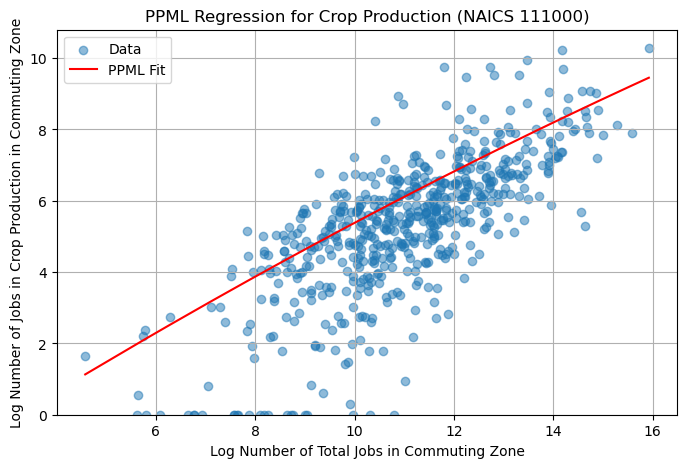

In [91]:
run_ppml_tj(df_cz, naics_code=111000)

In [92]:
def run_ppml_sj(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Employment_Share ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(df_industry['Log_Total_Jobs_CZ'],(df_industry['Employment_Share']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Share'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_Jobs_CZ')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_Jobs_CZ'], (sorted_df['Predicted_Share']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Number of Total Jobs in Commuting Zone")
    plt.ylabel(f"Share of Jobs in {industry_name} in Commuting Zone")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)
    
    # Prevent y-axis from dropping below zero
    #plt.ylim(bottom=0)
    
    # Show plot
    plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Employment_Share   No. Observations:                  583
Model:                            GLM   Df Residuals:                      580
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.786
Date:                Tue, 11 Mar 2025   Deviance:                       6.5864
Time:                        18:23:08   Pearson chi2:                     13.4
No. Iterations:                     5   Pseudo R-squ. (CS):           0.001262
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

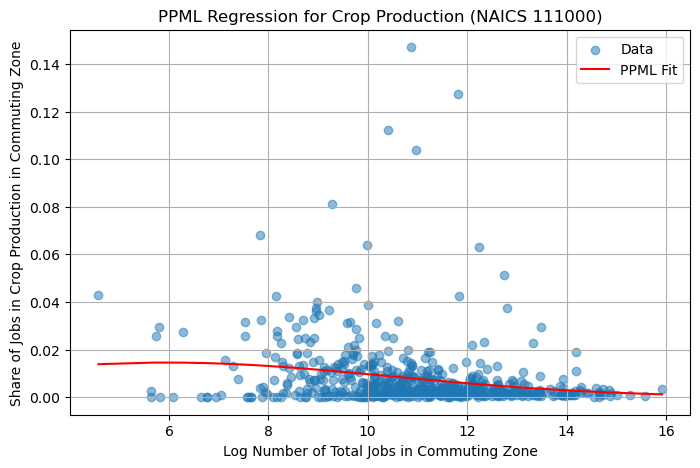

In [93]:
run_ppml_sj(df_cz, naics_code=111000)

In [94]:
df_cz['Industry'] = df_cz['Industry'].astype(str)

C:\Users\ConnorChristensen\AppData\Local\Temp\ipykernel_58644\2919434685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cz['Industry'] = df_cz['Industry'].astype(str)


In [95]:
scaling_coefficients = {}

for naics_code in df_cz['Industry'].astype(str).unique():
    df_industry = df_cz[df_cz['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Jobs_CZ ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_Jobs_CZ", np.nan)
        beta_2 = model.params.get("Log_Total_Jobs_CZ_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept_tj", "Beta1_tj", "Beta2_tj"])
df_scaling.reset_index(inplace=True)
df_scaling.rename(columns={"index": "Industry"}, inplace=True)

Processing Industry: 111000, Observations: 584
Processing Industry: 112000, Observations: 584
Processing Industry: 113110, Observations: 584
Processing Industry: 113210, Observations: 584
Processing Industry: 113310, Observations: 584
Processing Industry: 114111, Observations: 584
Processing Industry: 114112, Observations: 584
Processing Industry: 114119, Observations: 584
Processing Industry: 114210, Observations: 584
Processing Industry: 115111, Observations: 584
Processing Industry: 115112, Observations: 584
Processing Industry: 115113, Observations: 584
Processing Industry: 115114, Observations: 584
Processing Industry: 115115, Observations: 584
Processing Industry: 115116, Observations: 584
Processing Industry: 115210, Observations: 584
Processing Industry: 115310, Observations: 584
Processing Industry: 211120, Observations: 584
Processing Industry: 211130, Observations: 584
Processing Industry: 212114, Observations: 584
Processing Industry: 212115, Observations: 584
Processing In

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 902999, Observations: 584
Processing Industry: 903611, Observations: 584
Processing Industry: 903612, Observations: 584
Processing Industry: 903619, Observations: 584
Processing Industry: 903622, Observations: 584
Processing Industry: 903999, Observations: 584
Processing Industry: 999999, Observations: 584


In [96]:
print(df_scaling.head(25))

   Industry  Intercept_tj   Beta1_tj  Beta2_tj
0    111000     -2.853885   0.909023 -0.008552
1    112000     -2.629523   1.160607 -0.034189
2    113110    -21.506141   3.489341 -0.127294
3    113210    -12.974563   1.876878 -0.056677
4    113310    -17.400035   3.446830 -0.133367
5    114111      4.861974  -1.191309  0.074910
6    114112    -15.606091   2.076479 -0.055802
7    114119    -88.597043  12.427563 -0.425779
8    114210     -1.356119  -0.009269  0.019757
9    115111    -11.445436   2.200628 -0.085963
10   115112     -5.882447   1.064486 -0.020220
11   115113    -12.096594   1.804221 -0.045352
12   115114    -22.341829   3.821455 -0.126980
13   115115    -61.919994   9.667828 -0.336470
14   115116    -12.180470   1.854485 -0.044814
15   115210    -11.214292   1.773329 -0.042184
16   115310    -15.476143   2.728468 -0.092939
17   211120      5.728267  -0.857824  0.064110
18   211130      2.891268  -0.469527  0.046319
19   212114    -25.270253   5.217375 -0.233011
20   212115  

In [97]:
df_cz = df_cz.merge(df_scaling, on="Industry", how="left")

In [98]:
df_cz.sort_values(by="Jobs_CZ", ascending=False).head(25)

Area Name  \
533631      La Paz County, AZ   
488371      La Paz County, AZ   
533635      La Paz County, AZ   
507437       Bronx County, NY   
488415      La Paz County, AZ   
529629     Calvert County, MD   
488416      La Paz County, AZ   
543599       Bronx County, NY   
543595       Bronx County, NY   
507441       Bronx County, NY   
539318        Cook County, IL   
549188      Austin County, TX   
507495       Bronx County, NY   
488361      La Paz County, AZ   
507451       Bronx County, NY   
435813      La Paz County, AZ   
499251        Cook County, IL   
539322        Cook County, IL   
278161      La Paz County, AZ   
481071  Barnstable County, MA   
499305        Cook County, IL   
330727      La Paz County, AZ   
542984      Bergen County, NJ   
529824  Barnstable County, MA   
546556        Love County, OK   

                                            Industry Name   Area Industry  \
533631  Elementary and Secondary Schools (Local Govern...   4012   903611   
488371  Services for the Elderly and Persons with Disa...   4012   624120   
533635  Local Government, Excluding Education and Hosp...   4012   903999   
507437                          Home Health Care Services  36005   621610   
488415                           Full-Service Restaurants   4012   722511   
529629  Federal Government, Civilian, Excluding Postal...  24009   901199   
488416                        Limited-Service Restaurants   4012   722513   
543599  Local Government, Excluding Education and Hosp...  36005   903999   
543595  Elementary and Secondary Schools (Local Govern...  36005   903611   
507441             General Medical and Surgical Hospitals  36005   622110   
539318  Elementary and Secondary Schools (Local Govern...  17031   903611   
549188  Elementary and Secondary Schools (Local Govern...  48015   903611   
507495                           Full-Service Restaurants  36005   722511   
488361             General Medical and Surgical Hospitals   4012   622110   
507451  Services for the Elderly and Persons with Disa...  36005   624120   
435813                            Temporary Help Services   4012   561320   
499251             General Medical and Surgical Hospitals  17031   622110   
539322  Local Government, Excluding Education and Hosp...  17031   903999   
278161  Supermarkets and Other Grocery (except Conveni...   4012   445110   
481071             General Medical and Surgical Hospitals  25001   622110   
499305                           Full-Service Restaurants  17031   722511   
330727                    General Warehousing and Storage   4012   493110   
542984  Elementary and Secondary Schools (Local Govern...  34003   903611   
529824  Elementary and Secondary Schools (Local Govern...  25001   903611   
546556  Elementary and Secondary Schools (Local Govern...  40085   903611   

        Year           Jobs   CZ20    Jobs_county        Jobs_CZ  \
533631  2024     365.600875   37.0     365.600875  390142.517541   
488371  2024      10.349681   37.0      10.349681  382934.016347   
533635  2024    1277.842495   37.0    1277.842495  361964.813349   
507437  2024   16093.000000  382.0   16093.000000  313703.416666   
488415  2024     191.750000   37.0     191.750000  301918.666667   
529629  2024     343.833333   91.0     343.833333  300724.166666   
488416  2024     184.583333   37.0     184.583333  295863.916667   
543599  2024   22056.592866  382.0   22056.592866  293202.756346   
543595  2024   32715.333333  382.0   32715.333333  246511.250000   
507441  2024   24873.666667  382.0   24873.666667  227844.034367   
539318  2024  112580.416667  152.0  112580.416667  216508.102854   
549188  2024    1041.583333  501.0    1041.583333  205592.712226   
507495  2024    5293.083333  382.0    5293.083333  201628.833333   
488361  2024     245.693914   37.0     245.693914  198152.443914   
507451  2024   14442.000000  382.0   14442.000000  173197.750000   
435813  2024       0.000000   37.0       0.000000  169482.583333   
49

In [99]:
# Compute expected employment using the scaling model
df_cz['Expected_Jobs'] = np.exp(
    df_cz['Intercept_tj'] + 
    df_cz['Beta1_tj'] * df_cz['Log_Total_Jobs_CZ'] + 
    df_cz['Beta2_tj'] * df_cz['Log_Total_Jobs_CZ_Squared']
)

In [101]:
# Compute employment deviation (actual - expected)
df_cz['Jobs_Deviation'] = df_cz['Jobs_CZ'] - df_cz['Expected_Jobs']

# Display the top industries with the highest deviations
df_cz.sort_values(by="Jobs_Deviation", ascending=False).head(10)

Area Name                                      Industry Name  \
529629  Calvert County, MD  Federal Government, Civilian, Excluding Postal...   
507437    Bronx County, NY                          Home Health Care Services   
505685    Clark County, NV                                      Casino Hotels   
488371   La Paz County, AZ  Services for the Elderly and Persons with Disa...   
534758   Colusa County, CA  State Government, Excluding Education and Hosp...   
488416   La Paz County, AZ                        Limited-Service Restaurants   
492984   Citrus County, FL                          Amusement and Theme Parks   
402321    Bronx County, NY   Investment Banking and Securities Intermediation   
375658  Calvert County, MD                   Computer Systems Design Services   
543599    Bronx County, NY  Local Government, Excluding Education and Hosp...   

         Area Industry  Year           Jobs   CZ20    Jobs_county  \
529629  24009   901199  2024     343.833333   91.0     343.833333   
507437  36005   621610  2024   16093.000000  382.0   16093.000000   
505685  32003   721120  2024  130192.666667  362.0  130192.666667   
488371   4012   624120  2024      10.349681   37.0      10.349681   
534758   6011   902999  2024      63.500000   62.0      63.500000   
488416   4012   722513  2024     184.583333   37.0     184.583333   
492984  12017   713110  2024       0.924234   98.0       0.924234   
402321  36005   523150  2024       2.375715  382.0       2.375715   
375658  24009   541512  2024      68.641344   91.0      68.641344   
543599  36005   903999  2024   22056.592866  382.0   22056.592866   

              Jobs_CZ  Total_Jobs_CZ  Employment_Share  Log_Total_Jobs_CZ  \
529629  300724.166666   2.292982e+06          0.131150          14.645364   
507437  313703.416666   5.829888e+06          0.053810          15.578508   
505685  130658.750000   1.124636e+06          0.116179          13.932970   
488371  382934.016347   8.224741e+06          0.046559          15.922657   
534758  106255.333333   1.113900e+06          0.095390          13.923378   
488416  295863.916667   8.224741e+06          0.035972          15.922657   
492984   74673.338107   1.581352e+06          0.047221          14.273791   
402321  103293.792382   5.829888e+06          0.017718          15.578508   
375658   85284.138996   2.292982e+06          0.037194          14.645364   
543599  293202.756346   5.829888e+06          0.050293          15.578508   

        Log_Total_Jobs_CZ_Squared  Intercept_tj   Beta1_tj  Beta2_tj  \
529629                 214.486679    -13.718070   2.517203 -0.059410   
507437                 242.689920      3.119809  -0.362100  0.058020   
505685                 194.127657    -74.127233  11.289556 -0.387770   
488371                 253.531017      8.281540  -1.133356  0.088099   
534758                 193.860453    -13.115918   2.646058 -0.072235   
488416                 253.531017     -4.001440   1.149599 -0.008066   
492984                 203.741109    -20.418151   2.749902 -0.054054   
402321                 242.689920    -12.188597   1.410368  0.002711   
375658                 214.486679    -45.379259   6.617356 -0.194155   
543599                 242.689920      4.729166  -0.144738  0.040652   

        Expected_Jobs  Jobs_Deviation  
529629   33014.017444   267710.149222  
507437  104790.865972   208912.550695  
505685    2678.527583   127980.222417  
488371  288166.497398    94767.518949  
534758   16689.816220    89565.517113  
488416  210714.522029    85149.394638  
492984    2490.602623    72182.735484  
402321   34226.703147    69067.089235  
375658   19743.926253    65540.212743  
543599  228679.899759    64522.856586

In [102]:
scaling_coefficients_sj = {}

for naics_code in df_cz['Industry'].astype(str).unique():
    df_industry = df_cz[df_cz['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Employment_Share ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_Jobs_CZ", np.nan)
        beta_2 = model.params.get("Log_Total_Jobs_CZ_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling_sj = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept_sj", "Beta1_sj", "Beta2_sj"])
df_scaling_sj.reset_index(inplace=True)
df_scaling_sj.rename(columns={"index": "Industry"}, inplace=True)

Processing Industry: 111000, Observations: 584
Processing Industry: 112000, Observations: 584
Processing Industry: 113110, Observations: 584
Processing Industry: 113210, Observations: 584
Processing Industry: 113310, Observations: 584
Processing Industry: 114111, Observations: 584
Processing Industry: 114112, Observations: 584
Processing Industry: 114119, Observations: 584
Processing Industry: 114210, Observations: 584
Processing Industry: 115111, Observations: 584
Processing Industry: 115112, Observations: 584
Processing Industry: 115113, Observations: 584
Processing Industry: 115114, Observations: 584
Processing Industry: 115115, Observations: 584
Processing Industry: 115116, Observations: 584
Processing Industry: 115210, Observations: 584
Processing Industry: 115310, Observations: 584
Processing Industry: 211120, Observations: 584
Processing Industry: 211130, Observations: 584
Processing Industry: 212114, Observations: 584
Processing Industry: 212115, Observations: 584
Processing In

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 902611, Observations: 584
Processing Industry: 902612, Observations: 584
Processing Industry: 902619, Observations: 584
Processing Industry: 902622, Observations: 584
Processing Industry: 902999, Observations: 584
Processing Industry: 903611, Observations: 584
Processing Industry: 903612, Observations: 584
Processing Industry: 903619, Observations: 584
Processing Industry: 903622, Observations: 584
Processing Industry: 903999, Observations: 584
Processing Industry: 999999, Observations: 584


In [103]:
print(df_scaling_sj.head(25))

   Industry  Intercept_sj   Beta1_sj  Beta2_sj
0    111000     -5.122574   0.299146 -0.025057
1    112000     -1.202903  -0.151586 -0.017708
2    113110     -4.849451  -0.676848  0.019952
3    113210    -48.047830   7.058494 -0.326308
4    113310    -15.623465   2.065417 -0.113681
5    114111    -12.895923   1.312831 -0.093513
6    114112    -12.490539   0.555043 -0.034267
7    114119     -6.775780  -1.189277  0.056475
8    114210     -7.919082   0.388747 -0.052472
9    115111    -27.004803   4.136878 -0.222764
10   115112    -13.931080   1.543371 -0.087049
11   115113     -7.752106   0.194257 -0.025574
12   115114    -21.902737   2.789394 -0.127399
13   115115    -11.932668   0.585725 -0.012998
14   115116    -17.520036   1.781836 -0.084569
15   115210     -0.825663  -1.140553  0.043882
16   115310    -15.614645   1.647631 -0.084957
17   211120     -6.267973   0.330005 -0.033341
18   211130    -18.428134   2.447746 -0.130394
19   212114    -41.767181   7.256851 -0.371721
20   212115  

In [104]:
df_cz = df_cz.merge(df_scaling_sj, on="Industry", how="left")

In [105]:
df_cz.sort_values(by="Jobs_CZ", ascending=False).head(25)

Area Name  \
533631      La Paz County, AZ   
488371      La Paz County, AZ   
533635      La Paz County, AZ   
507437       Bronx County, NY   
488415      La Paz County, AZ   
529629     Calvert County, MD   
488416      La Paz County, AZ   
543599       Bronx County, NY   
543595       Bronx County, NY   
507441       Bronx County, NY   
539318        Cook County, IL   
549188      Austin County, TX   
507495       Bronx County, NY   
488361      La Paz County, AZ   
507451       Bronx County, NY   
435813      La Paz County, AZ   
499251        Cook County, IL   
539322        Cook County, IL   
278161      La Paz County, AZ   
481071  Barnstable County, MA   
499305        Cook County, IL   
330727      La Paz County, AZ   
542984      Bergen County, NJ   
529824  Barnstable County, MA   
546556        Love County, OK   

                                            Industry Name   Area Industry  \
533631  Elementary and Secondary Schools (Local Govern...   4012   903611   
488371  Services for the Elderly and Persons with Disa...   4012   624120   
533635  Local Government, Excluding Education and Hosp...   4012   903999   
507437                          Home Health Care Services  36005   621610   
488415                           Full-Service Restaurants   4012   722511   
529629  Federal Government, Civilian, Excluding Postal...  24009   901199   
488416                        Limited-Service Restaurants   4012   722513   
543599  Local Government, Excluding Education and Hosp...  36005   903999   
543595  Elementary and Secondary Schools (Local Govern...  36005   903611   
507441             General Medical and Surgical Hospitals  36005   622110   
539318  Elementary and Secondary Schools (Local Govern...  17031   903611   
549188  Elementary and Secondary Schools (Local Govern...  48015   903611   
507495                           Full-Service Restaurants  36005   722511   
488361             General Medical and Surgical Hospitals   4012   622110   
507451  Services for the Elderly and Persons with Disa...  36005   624120   
435813                            Temporary Help Services   4012   561320   
499251             General Medical and Surgical Hospitals  17031   622110   
539322  Local Government, Excluding Education and Hosp...  17031   903999   
278161  Supermarkets and Other Grocery (except Conveni...   4012   445110   
481071             General Medical and Surgical Hospitals  25001   622110   
499305                           Full-Service Restaurants  17031   722511   
330727                    General Warehousing and Storage   4012   493110   
542984  Elementary and Secondary Schools (Local Govern...  34003   903611   
529824  Elementary and Secondary Schools (Local Govern...  25001   903611   
546556  Elementary and Secondary Schools (Local Govern...  40085   903611   

        Year           Jobs   CZ20    Jobs_county        Jobs_CZ  \
533631  2024     365.600875   37.0     365.600875  390142.517541   
488371  2024      10.349681   37.0      10.349681  382934.016347   
533635  2024    1277.842495   37.0    1277.842495  361964.813349   
507437  2024   16093.000000  382.0   16093.000000  313703.416666   
488415  2024     191.750000   37.0     191.750000  301918.666667   
529629  2024     343.833333   91.0     343.833333  300724.166666   
488416  2024     184.583333   37.0     184.583333  295863.916667   
543599  2024   22056.592866  382.0   22056.592866  293202.756346   
543595  2024   32715.333333  382.0   32715.333333  246511.250000   
507441  2024   24873.666667  382.0   24873.666667  227844.034367   
539318  2024  112580.416667  152.0  112580.416667  216508.102854   
549188  2024    1041.583333  501.0    1041.583333  205592.712226   
507495  2024    5293.083333  382.0    5293.083333  201628.833333   
488361  2024     245.693914   37.0     245.693914  198152.443914   
507451  2024   14442.000000  382.0   14442.000000  173197.750000   
435813  2024       0.000000   37.0       0.000000  169482.583333   
49

In [106]:
df_cz['Expected_Share'] = np.exp(
    df_cz['Intercept_sj'] + 
    df_cz['Beta1_sj'] * df_cz['Log_Total_Jobs_CZ'] + 
    df_cz['Beta2_sj'] * df_cz['Log_Total_Jobs_CZ_Squared']
)

In [107]:
# Compute employment deviation (actual - expected)
df_cz['Share_Deviation'] = df_cz['Employment_Share'] - df_cz['Expected_Share']

# Display the top industries with the highest deviations
df_cz.sort_values(by="Share_Deviation", ascending=False).head(10)

Area Name  \
65631       Aleutians East Borough, AK   
65721   Aleutians West Census Area, AK   
32401                 Grant County, NE   
55457                 Clark County, KS   
14243     Northwest Arctic Borough, AK   
532926        Kusilvak Census Area, AK   
487814             Yakutat Borough, AK   
539035                 Cass County, IL   
532930        Kusilvak Census Area, AK   
194884               Dickey County, ND   

                                            Industry Name   Area Industry  \
65631           Seafood Product Preparation and Packaging   2013   311710   
65721           Seafood Product Preparation and Packaging   2016   311710   
32401                                   Animal Production  31075   112000   
55457                Animal (except Poultry) Slaughtering  20025   311611   
14243               Copper, Nickel, Lead, and Zinc Mining   2188   212230   
532926  Elementary and Secondary Schools (Local Govern...   2158   903611   
487814                  All Other Outpatient Care Centers   2282   621498   
539035  State Government, Excluding Education and Hosp...  17017   902999   
532930  Local Government, Excluding Education and Hosp...   2158   903999   
194884               Construction Machinery Manufacturing  38021   333120   

        Year         Jobs   CZ20  Jobs_county       Jobs_CZ  Total_Jobs_CZ  \
65631   2024  1510.527049   13.0  1510.527049   1510.527049    1965.809532   
65721   2024  1847.052778   14.0  1847.052778   1847.052778    3305.285534   
32401   2024   119.333333  360.0   119.333333    119.333333     280.657627   
55457   2024     0.000000  204.0     0.000000   6043.351299   23251.276647   
14243   2024   694.497689   27.0   694.497689    694.497689    2928.366543   
532926  2024   664.083333   24.0   664.083333    664.083333    1955.732235   
487814  2024    82.302416   17.0    82.302416     82.302416     333.638981   
539035  2024     0.000000  146.0     0.000000  42652.100141  177536.385272   
532930  2024   653.166667   24.0   653.166667    653.166667    1955.732235   
194884  2024     0.000000  413.0     0.000000   1666.654947    7955.035544   

        ...  Intercept_tj  Beta1_tj  Beta2_tj  Expected_Jobs  Jobs_Deviation  \
65631   ...     12.414284 -1.877908  0.096398      41.137826     1469.389223   
65721   ...     12.414284 -1.877908  0.096398      34.018263     1813.034515   
32401   ...     -2.629523  1.160607 -0.034189      16.887058      102.446276   
55457   ...    -10.983605  2.660428 -0.104292     185.357984     5857.993316   
14243   ...      3.776484 -0.379495  0.030025      14.301106      680.196583   
532926  ...      1.218363  0.448532  0.017511     276.801707      387.281626   
487814  ...     -0.367086  0.058333  0.035974       3.274644       79.027772   
539035  ...    -13.115918  2.646058 -0.072235    4079.158199    38572.941943   
532930  ...      4.729166 -0.144738  0.040652     390.350272      262.816394   
194884  ...    -20.858182  3.808313 -0.135878      10.862562     1655.792386   

        Intercept_sj  Beta1_sj  Beta2_sj  Expected_Share  Share_Deviation  
65631     -22.225353  5.485152 -0.392520        0.040666         0.727734  
65721     -22.225353  5.485152 -0.392520        0.028676         0.530142  
32401      -1.202903 -0.151586 -0.017708        0.072793         0.352399  
55457     -42.213618  7.429623 -0.368138        0.008838         0.251077  
14243     -12.737071  1.870975 -0.126793        0.002791         0.234371  
532926     -0.858280 -0.201963  0.003050        0.109295         0.230262  
487814      2.127998 -1.374045  0.054242        0.017877         0.228804  
539035     -4.712195  0.265807 -0.016326        0.020557         0.219687  
532930      0.051342 -0.330479  0.005894        0.120670         0.213305  
194884    -17.164045  2.240283 -0.114746        0.001838         0.207672  

[10 rows x 23 columns]

In [108]:
def get_commuting_zone(df, county_name):
    """
    Returns the commuting zone (CZ20) for a given county name.
    
    Parameters:
    df (DataFrame): The dataset containing "Area Name" (county names) and "CZ20" (commuting zones).
    county_name (str): The name of the county to look up.
    
    Returns:
    array or None: The unique commuting zone(s) if found, otherwise None.
    """
    result = df[df["Area Name"].str.contains(county_name, case=False, na=False)]
    return result["CZ20"].unique() if not result.empty else None



county_name = "Larimer County, CO"                            #Fort Collins, CO
larimer = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {larimer}")

county_name = "Yellowstone County, MT"                            #Billings, MT
yellowstone = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {yellowstone}")

county_name = "Gallatin County, MT"                                #Bozeman, MT
gallatin = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {gallatin}")

county_name = "Pennington County, SD"                           #Rapid City, SD
pennington = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {pennington}")

county_name = "Scotts Bluff County, NE"                        #Scottsbluff, NE
scottsbluff = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {scottsbluff}")

county_name = "Bannock County, ID"                               #Pocatello, ID
bannock = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {bannock}")

county_name = "Cache County, UT"                                     #Logan, UT
cache = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {cache}")

Commuting Zone for Larimer County, CO: [84.]
Commuting Zone for Yellowstone County, MT: [327.]
Commuting Zone for Gallatin County, MT: [326.]
Commuting Zone for Pennington County, SD: [479.]
Commuting Zone for Scotts Bluff County, NE: [348.]
Commuting Zone for Bannock County, ID: [131.]
Commuting Zone for Cache County, UT: [139.]


In [109]:
# Combine all commuting zones into a set (removes duplicates)
target_czs = set()

for cz in [larimer, yellowstone, gallatin, pennington, scottsbluff, bannock, cache]:
    if cz is not None:
        if isinstance(cz, np.ndarray):  # Extract value if it's an array
            target_czs.update(cz.tolist())
        else:
            target_czs.add(cz)
            
# Convert to sorted list for readability
target_czs = sorted(target_czs)
print(f"Target Commuting Zones: {target_czs}")


Target Commuting Zones: [84.0, 131.0, 139.0, 326.0, 327.0, 348.0, 479.0]


In [112]:
# Filter dataset to only the selected commuting zones
df_around_wy = df_cz[df_cz['CZ20'].isin(target_czs)]



Area Name  \
542000      Banner County, NE   
444790     Bannock County, ID   
541996      Banner County, NE   
502491      Carbon County, MT   
540962  Broadwater County, MT   
502444  Broadwater County, MT   
548147       Butte County, SD   
541990      Banner County, NE   
235294    Franklin County, ID   
536590     Larimer County, CO   

                                            Industry Name   Area Industry  \
542000                       Hospitals (Local Government)  31007   903622   
444790  Research and Development in the Physical, Engi...  16005   541715   
541996  State Government, Excluding Education and Hosp...  31007   902999   
502491             General Medical and Surgical Hospitals  30009   622110   
540962  State Government, Excluding Education and Hosp...  30007   902999   
502444           Hotels (except Casino Hotels) and Motels  30007   721110   
548147  Federal Government, Civilian, Excluding Postal...  46019   901199   
541990  Federal Government, Civilian, Excluding Postal...  31007   901199   
235294  Guided Missile and Space Vehicle Propulsion Un...  16041   336415   
536590                       Hospitals (State Government)   8069   902622   

        Year         Jobs   CZ20  Jobs_county      Jobs_CZ  Total_Jobs_CZ  \
542000  2024     0.000000  348.0     0.000000  4504.269441   67176.227307   
444790  2024     8.416667  131.0     8.416667  7453.559593  158324.310709   
541996  2024     0.000000  348.0     0.000000  4280.942701   67176.227307   
502491  2024   124.708408  327.0   124.708408  6881.098066   95582.921444   
540962  2024    16.333333  326.0    16.333333  7015.750000  119739.967157   
502444  2024    27.112147  326.0    27.112147  5003.374522  119739.967157   
548147  2024    39.916667  479.0    39.916667  3773.583333   91852.700709   
541990  2024     1.000000  348.0     1.000000  2714.916667   67176.227307   
235294  2024     0.000000  139.0     0.000000  2264.575425   92918.977464   
536590  2024  8097.750000   84.0  8097.750000  8097.750000  303165.691624   

        ...  Intercept_tj  Beta1_tj  Beta2_tj  Expected_Jobs  Jobs_Deviation  \
542000  ...      6.905477 -0.693620  0.057325     532.760849     3971.508592   
444790  ...    -39.602098  5.781339 -0.167164     285.243931     7168.315662   
541996  ...    -13.115918  2.646058 -0.072235    1589.056353     2691.886348   
502491  ...     -6.279686  1.474149 -0.019082    3347.483357     3533.614710   
540962  ...    -13.115918  2.646058 -0.072235    2830.001354     4185.748646   
502444  ...      1.223702  0.182073  0.028438    1395.355626     3608.018896   
548147  ...    -13.718070  2.517203 -0.059410    1464.979291     2308.604042   
541990  ...    -13.718070  2.517203 -0.059410    1013.395387     1701.521279   
235294  ...     -2.357731  0.217359  0.021356      18.605465     2245.969959   
536590  ...    -15.472759  2.476838 -0.056031     956.602520     7141.147480   

        Intercept_sj  Beta1_sj  Beta2_sj  Expected_Share  Share_Deviation  
542000    -10.569914  1.485586 -0.084485        0.011163         0.055889  
444790    -19.243465  1.631008 -0.046374        0.001723         0.045355  
541996     -4.712195  0.265807 -0.016326        0.022943         0.040784  
502491     -4.713195  0.202597 -0.007553        0.033939         0.038052  
540962     -4.712195  0.265807 -0.016326        0.021573         0.037019  
502444     -2.573716 -0.148466 -0.000474        0.012594         0.029191  
548147      0.351488 -0.774153  0.032541        0.014326         0.026757  
541990      0.351488 -0.774153  0.032541        0.014509         0.025906  
235294    -54.174963  8.127047 -0.357451        0.000341         0.024030  
536590    -12.856435  1.026892 -0.037099        0.003011         0.023699  

[10 rows x 23 columns]

In [125]:
df_around_wy.sort_values(by="Share_Deviation", ascending=False).head(10)

Area Name  \
542000      Banner County, NE   
444790     Bannock County, ID   
541996      Banner County, NE   
502491      Carbon County, MT   
540962  Broadwater County, MT   
502444  Broadwater County, MT   
548147       Butte County, SD   
541990      Banner County, NE   
235294    Franklin County, ID   
536590     Larimer County, CO   

                                            Industry Name   Area Industry  \
542000                       Hospitals (Local Government)  31007   903622   
444790  Research and Development in the Physical, Engi...  16005   541715   
541996  State Government, Excluding Education and Hosp...  31007   902999   
502491             General Medical and Surgical Hospitals  30009   622110   
540962  State Government, Excluding Education and Hosp...  30007   902999   
502444           Hotels (except Casino Hotels) and Motels  30007   721110   
548147  Federal Government, Civilian, Excluding Postal...  46019   901199   
541990  Federal Government, Civilian, Excluding Postal...  31007   901199   
235294  Guided Missile and Space Vehicle Propulsion Un...  16041   336415   
536590                       Hospitals (State Government)   8069   902622   

        Year         Jobs   CZ20  Jobs_county      Jobs_CZ  Total_Jobs_CZ  \
542000  2024     0.000000  348.0     0.000000  4504.269441   67176.227307   
444790  2024     8.416667  131.0     8.416667  7453.559593  158324.310709   
541996  2024     0.000000  348.0     0.000000  4280.942701   67176.227307   
502491  2024   124.708408  327.0   124.708408  6881.098066   95582.921444   
540962  2024    16.333333  326.0    16.333333  7015.750000  119739.967157   
502444  2024    27.112147  326.0    27.112147  5003.374522  119739.967157   
548147  2024    39.916667  479.0    39.916667  3773.583333   91852.700709   
541990  2024     1.000000  348.0     1.000000  2714.916667   67176.227307   
235294  2024     0.000000  139.0     0.000000  2264.575425   92918.977464   
536590  2024  8097.750000   84.0  8097.750000  8097.750000  303165.691624   

        ...  Intercept_tj  Beta1_tj  Beta2_tj  Expected_Jobs  Jobs_Deviation  \
542000  ...      6.905477 -0.693620  0.057325     532.760849     3971.508592   
444790  ...    -39.602098  5.781339 -0.167164     285.243931     7168.315662   
541996  ...    -13.115918  2.646058 -0.072235    1589.056353     2691.886348   
502491  ...     -6.279686  1.474149 -0.019082    3347.483357     3533.614710   
540962  ...    -13.115918  2.646058 -0.072235    2830.001354     4185.748646   
502444  ...      1.223702  0.182073  0.028438    1395.355626     3608.018896   
548147  ...    -13.718070  2.517203 -0.059410    1464.979291     2308.604042   
541990  ...    -13.718070  2.517203 -0.059410    1013.395387     1701.521279   
235294  ...     -2.357731  0.217359  0.021356      18.605465     2245.969959   
536590  ...    -15.472759  2.476838 -0.056031     956.602520     7141.147480   

        Intercept_sj  Beta1_sj  Beta2_sj  Expected_Share  Share_Deviation  
542000    -10.569914  1.485586 -0.084485        0.011163         0.055889  
444790    -19.243465  1.631008 -0.046374        0.001723         0.045355  
541996     -4.712195  0.265807 -0.016326        0.022943         0.040784  
502491     -4.713195  0.202597 -0.007553        0.033939         0.038052  
540962     -4.712195  0.265807 -0.016326        0.021573         0.037019  
502444     -2.573716 -0.148466 -0.000474        0.012594         0.029191  
548147      0.351488 -0.774153  0.032541        0.014326         0.026757  
541990      0.351488 -0.774153  0.032541        0.014509         0.025906  
235294    -54.174963  8.127047 -0.357451        0.000341         0.024030  
536590    -12.856435  1.026892 -0.037099        0.003011         0.023699  

[10 rows x 23 columns]

In [130]:

# Select relevant columns
columns_to_keep = ["CZ20", "Industry Name", "Industry", "Jobs_CZ", "Total_Jobs_CZ", "Employment_Share", "Expected_Share", "Share_Deviation"]

# Get top 5 industries per CZ20 based on Share_Deviation
df_top_5_per_cz = (
    df_around_wy.sort_values(by=["CZ20", "Share_Deviation"], ascending=[True, False])
    .groupby("CZ20")
    .head(5)
)[columns_to_keep]  # Keep only selected columns



In [131]:
from IPython.display import display

# Display the dataframe properly in Jupyter Notebook
display(df_top_5_per_cz)

CZ20                                      Industry Name Industry  \
536590   84.0                       Hospitals (State Government)   902622   
73547    84.0               Animal (except Poultry) Slaughtering   311611   
536588   84.0  Colleges, Universities, and Professional Schoo...   902612   
21004    84.0      Support Activities for Oil and Gas Operations   213112   
20971    84.0                                  Animal Production   112000   
444790  131.0  Research and Development in the Physical, Engi...   541715   
497353  131.0  Freestanding Ambulatory Surgical and Emergency...   621493   
444845  131.0             Hazardous Waste Treatment and Disposal   562211   
444817  131.0    Telemarketing Bureaus and Other Contact Centers   561422   
76871   131.0            Dried and Dehydrated Food Manufacturing   311423   
235294  139.0  Guided Missile and Space Vehicle Propulsion Un...   336415   
538703  139.0  Colleges, Universities, and Professional Schoo...   902612   
393014  139.0                          Other Accounting Services   541219   
77594   139.0                               Cheese Manufacturing   311513   
445510  139.0  Research and Development in the Physical, Engi...   541715   
540962  326.0  State Government, Excluding Education and Hosp...   902999   
502444  326.0           Hotels (except Casino Hotels) and Motels   721110   
540959  326.0  Colleges, Universities, and Professional Schoo...   902612   
29392   326.0  New Single-Family Housing Construction (except...   236115   
502455  326.0                           Full-Service Restaurants   722511   
502491  327.0             General Medical and Surgical Hospitals   622110   
29454   327.0                             Other Metal Ore Mining   212290   
82079   327.0                               Petroleum Refineries   324110   
397360  327.0                                 Commercial Banking   522110   
502527  327.0                          Other Gambling Industries   713290   
542000  348.0                       Hospitals (Local Government)   903622   
541996  348.0  State Government, Excluding Education and Hosp...   902999   
541990  348.0  Federal Government, Civilian, Excluding Postal...   901199   
346747  348.0                    General Warehousing and Storage   493110   
541998  348.0  Colleges, Universities, and Professional Schoo...   903612   
548147  479.0  Federal Government, Civilian, Excluding Postal...   901199   
516171  479.0             General Medical and Surgical Hospitals   622110   
516214  479.0           Hotels (except Casino Hotels) and Motels   721110   
516215  479.0                                      Casino Hotels   721120   
463617  479.0                 Offices of Other Holding Companies   551112   

             Jobs_CZ  Total_Jobs_CZ  Employment_Share  Expected_Share  \
536590   8097.750000  303165.691624          0.026711        0.003011   
73547    6249.987209  303165.691624          0.020616        0.000836   
536588  10886.250000  303165.691624          0.035909        0.018345   
21004    5359.488972  303165.691624          0.017678        0.002006   
20971    3690.415341  303165.691624          0.012173        0.002639   
444790   7453.559593  158324.310709          0.047078        0.001723   
497353   2068.766268  158324.310709          0.013067        0.001064   
444845   1865.222667  158324.310709          0.011781        0.000406   
444817   1871.929813  158324.310709          0.011823        0.002017   
76871    1545.326849  158324.310709          0.009761        0.000221   
235294   2264.575425   92918.977464          0.024372        0.000341   
538703   3892.833333   92918.977464          0.041895        0.019046   
393014   1892.835631   92918.977464          0.020371        0.001476   
77594    1672.378332   92918.977464          0.017998        0.001252   
445510   1415.908534   92918.977464          0.015238        0.001289   
540962   7015.750000  119739.967157          0.058592        0.02157